In [1]:
# Notebook created Novembere 21, 2024. 
# Copied from my classify_showers nb from when I studied pi0s.
# I thought I might look straight at the CAFs for the new ALPs Gray just made. But, I'm not going to any more, so abandoning this nb. 


In [1]:
1+2

3

In [7]:
# Libraries
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
import os
import pickle
import heapq
import math
from scipy.stats import norm
from scipy.optimize import curve_fit
#import matplotlib.mlab as mlab
#import plotly.express as px #
from matplotlib.colors import ListedColormap

# Local stuff
from branches import *
#from panda_helpers import *
#from helpers import *

## Set of commands to run if I want to look at a whole dataframe:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

## Check pandas version:
#print(pd.__version__)
#pd.show_versions()

In [4]:
# CHOOSE YOUR SAMPLE:

path = '/pnfs/icarus/scratch/users/gputnam/DMCP2023G/jamie-gen'
#sample_dir_to_save_to = 'classify_showers'

In [3]:
##%%time
### I am loading stuff in from the cafs as-is: not requiring that they correspond to pi0s.
# Only save stuff from slices that are not tagged as clear cosmics.

slices_df = []
#prims_df = []
shw_df = []
#shw_matches_df = []
trueparts_df = []
file_list = []

for root, direc, files in os.walk(path):
    for file in files:
        #if file != 'flatcaf_0.root':
        #    continue
            
        print(file)
        file_list.append(file)
        f = uproot.open(root+'/'+file)
        events = f['recTree;11']
        
        ###
        # GET RID OF SHOWERS FROM SLICES THAT ARE LABELED AS CLEAR COSMICS.
        slc = loadbranches(events, slcbranches)
        shw = loadbranches(events, slc_shw_branches)
        # NOTE: I need to fix shw_matches if I want to use it. (get rid of clear cosmic slices)
        #shw_matches = loadbranches(events, slc_shw_matches_branches)
    
        shw_clear_cosmic = []
        for idx in shw.index:
            shw_clear_cosmic.append(slc.loc[idx[0], idx[1]]['rec.slc.is_clear_cosmic'])
        shw['rec.slc.is_clear_cosmic'] = shw_clear_cosmic
        slc = slc[slc['rec.slc.is_clear_cosmic'] == 0]
        shw = shw[shw['rec.slc.is_clear_cosmic'] == 0]
        #print(shw.shape)
        
        ###

        slices_df.append(slc)
        #prims_df.append(loadbranches(events, slc_prim))
        shw_df.append(shw)
        #shw_matches_df.append(shw_matches)
        trueparts_df.append(loadbranches(events, trueparticle_branches))

slices_df = pd.concat(slices_df, keys=file_list, names=['file'])
#prims_df = pd.concat(prims_df, keys=file_list, names=['file'])
shw_df = pd.concat(shw_df, keys=file_list, names=['file'])
#shw_matches_df = pd.concat(shw_matches_df, keys=file_list, names=['file'])
trueparts_df = pd.concat(trueparts_df, keys=file_list, names=['file'])

# Save to pickles:

slices_df.to_pickle(sample_dir_to_save_to + "/slices_df")
#prims_df.to_pickle(sample_dir_to_save_to + "/prims_df")
shw_df.to_pickle(sample_dir_to_save_to + "/shw_df")
#shw_matches_df.to_pickle(sample_dir_to_save_to + "/shw_matches_df")
trueparts_df.to_pickle(sample_dir_to_save_to + "/trueparts_df")

flatcaf_0.root


KeyboardInterrupt: 

In [4]:
# Load from pickles:

slices_df = pd.read_pickle(sample_dir_to_save_to + "/slices_df")
#prims_df = pd.read_pickle(sample_dir_to_save_to + "/prims_df")
shw_df = pd.read_pickle(sample_dir_to_save_to + "/shw_df")
#shw_matches_df = pd.read_pickle(sample_dir_to_save_to + "/shw_matches_df")
trueparts_df = pd.read_pickle(sample_dir_to_save_to + "/trueparts_df")

print('slices_df.shape: ', slices_df.shape)
#print('prims_df.shape: ', prims_df.shape)
print('shw_df.shape: ', shw_df.shape)
#print('shw_matches_df.shape: ', shw_matches_df.shape)
#print('trueparts_df.shape: ', trueparts_df.shape)


slices_df.shape:  (166144, 25)
shw_df.shape:  (133666, 85)


In [14]:
%%time
# takes 1 hour 5 minutes.

## 1) Apply some selection cuts on the showers:
## - Apply a containment cut to the showers dataframe
## - Exclude showers with a bad G4ID
## - Exclude showers with a bad energy

## 2) Add True and Best_Match particle type to shower dataframe:

showers_pass_cuts = []
buffer = 0 # cm

#shw_true_pdg = []
#shw_best_match_pdg = []

file = -1
entry = -1

for address in shw_df.index: # This address is the address to a shower in a slice.
   
    if address[0] != file:
        file = address[0]
        print('file: ', file)
    #if address[1] != entry:
    #    entry = address[1]
    #    print('\t entry: ', entry)
    
    x_start = shw_df.loc[(address)]['rec.slc.reco.shw.start.x']
    x_end = shw_df.loc[(address)]['rec.slc.reco.shw.end.x']
    y_start = shw_df.loc[(address)]['rec.slc.reco.shw.start.y']
    y_end = shw_df.loc[(address)]['rec.slc.reco.shw.end.y']
    z_start = shw_df.loc[(address)]['rec.slc.reco.shw.start.z']
    z_end = shw_df.loc[(address)]['rec.slc.reco.shw.end.z']
    
    xpass = ( ( (-358.49+25+buffer < x_start < 61.94-25-buffer) | (61.94+25+buffer < x_start < 358.49-25-buffer) )
             & ( (-358.49+25+buffer < x_end < 61.94-25-buffer) | (61.94+25+buffer < x_end < 358.49-25-buffer) )
            )
    ypass = (-181.86+25+buffer < y_start < 134.96-25-buffer) & (-181.86+25+buffer < y_end < 134.96-25-buffer)
    zpass = (-894.95+30+buffer < z_start < 894.95-50-buffer) & (-894.95+30+buffer < z_end < 894.95-50-buffer)
    
    truthP_g4id_pass = shw_df.loc[(address)]['rec.slc.reco.shw.truth.p.G4ID'] > 0
    bestmatch_g4id_pass = shw_df.loc[(address)]['rec.slc.reco.shw.truth.bestmatch.G4ID'] > 0
   
    Epass = shw_df.loc[(address)]['rec.slc.reco.shw.bestplane_energy'] > 0
    
    if xpass & ypass & zpass & truthP_g4id_pass & bestmatch_g4id_pass & Epass:
        showers_pass_cuts.append(address)
        #trueparts = trueparts_df.loc[(address[0], address[1])]
        ## FIX!! 
        #shw_true_pdg.append(int(trueparts[trueparts['rec.true_particles.G4ID'] == shw_df.loc[address]['rec.slc.reco.shw.truth.p.G4ID']]['rec.true_particles.pdg']))
        #shw_best_match_pdg.append(int(trueparts[trueparts['rec.true_particles.G4ID'] == shw_df.loc[address]['rec.slc.reco.shw.truth.bestmatch.G4ID']]['rec.true_particles.pdg']))
      
print('Requiring shower containment, good G4IDs, and good energies drops number of showers from %a to %a.' % (shw_df.shape[0], len(showers_pass_cuts) ))

shw_df = shw_df.loc[showers_pass_cuts]

#shw_df['truth.p.pdg'] = shw_true_pdg
#shw_df['bestmatch.pdg'] = shw_best_match_pdg

# Save to pickles:

shw_df.to_pickle(sample_dir_to_save_to + "/shw_df_passCuts")

file:  flatcaf_0.root
file:  flatcaf_10.root
file:  flatcaf_11.root
file:  flatcaf_12.root
file:  flatcaf_13.root
file:  flatcaf_14.root
file:  flatcaf_15.root
file:  flatcaf_16.root
file:  flatcaf_17.root
file:  flatcaf_18.root
file:  flatcaf_19.root
file:  flatcaf_1.root
file:  flatcaf_2.root
file:  flatcaf_3.root
file:  flatcaf_4.root
file:  flatcaf_5.root
file:  flatcaf_6.root
file:  flatcaf_7.root
file:  flatcaf_8.root
file:  flatcaf_9.root
Requiring shower containment, good G4IDs, and good energies drops number of showers from 133666 to 69006.
CPU times: user 10min, sys: 353 ms, total: 10min
Wall time: 10min 1s


In [5]:
# Load from pickles AFTER cuts and storing shower particle pdgs: (Start here!)

slices_df = pd.read_pickle(sample_dir_to_save_to + "/slices_df")
#prims_df = pd.read_pickle(sample_dir_to_save_to + "/prims_df")
shw_df = pd.read_pickle(sample_dir_to_save_to + "/shw_df_passCuts")
shw_matches_df = pd.read_pickle(sample_dir_to_save_to + "/shw_matches_df")
trueparts_df = pd.read_pickle(sample_dir_to_save_to + "/trueparts_df")

shw_df_includes_clear_cosmics = shw_df

print(slices_df.shape)
print(shw_df.shape)


(166144, 25)
(69006, 85)


In [6]:
shw_df.columns

Index(['rec.slc.reco.shw.bestplane', 'rec.slc.reco.shw.bestplane_energy',
       'rec.slc.reco.shw.plane.0.energy', 'rec.slc.reco.shw.plane.1.energy',
       'rec.slc.reco.shw.plane.2.energy', 'rec.slc.reco.shw.plane.0.nHits',
       'rec.slc.reco.shw.plane.1.nHits', 'rec.slc.reco.shw.plane.2.nHits',
       'rec.slc.reco.shw.plane.0.dEdx', 'rec.slc.reco.shw.plane.0.dEdx',
       'rec.slc.reco.shw.plane.1.dEdx', 'rec.slc.reco.shw.plane.1.dEdx',
       'rec.slc.reco.shw.plane.2.dEdx', 'rec.slc.reco.shw.plane.2.dEdx',
       'rec.slc.reco.shw.open_angle', 'rec.slc.reco.shw.len',
       'rec.slc.reco.shw.dir.x', 'rec.slc.reco.shw.dir.y',
       'rec.slc.reco.shw.dir.z', 'rec.slc.reco.shw.end.x',
       'rec.slc.reco.shw.end.y', 'rec.slc.reco.shw.end.z',
       'rec.slc.reco.shw.start.x', 'rec.slc.reco.shw.start.y',
       'rec.slc.reco.shw.start.z', 'rec.slc.reco.shw.pfp.id',
       'rec.slc.reco.shw.pfp.parent', 'rec.slc.reco.shw.pfp.parent_is_primary',
       'rec.slc.reco.shw.pfp.slcID'

In [6]:
# MAKE SUBSAMPLES BASED ON TRUE PARTICLE ENERGY AND SHOWER COMPLETENESS CUTOFFS

#print(shw_df.shape)
#print(shw_df.columns)
#print(pd.read_pickle(sample_dir_to_save_to + "/shw_df").shape)

# How many electron- and photon- showers are in the sample?

electrons = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] == 11) | (shw_df['rec.slc.reco.shw.truth.p.pdg'] == -11)]
#pos = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == -11]
photons = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] == 22)]
muons = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] == 13) | (shw_df['rec.slc.reco.shw.truth.p.pdg'] == -13)]
protons = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] == 2212)]
#other = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] != 22) & (shw_df['rec.slc.reco.shw.truth.p.pdg'] != 11) & (shw_df['rec.slc.reco.shw.truth.p.pdg'] != -11)]

print('total number of showers (after preselection): ', shw_df.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons: ', electrons.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to photons: ', photons.shape[0]) # Compare this to number of photon showers you have at high completeness.
print('... rec.slc.reco.shw.truth.p.pdg corresponding to muons: ', muons.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to protons: ', protons.shape[0])
#print('... rec.slc.reco.shw.truth.p.pdg corresponding to something else: ', other.shape[0])
print('')

# Only consider showers whose true particle has an energy of at least 50 MeV ('suff' is for 'sufficient energy'):

suff_thresh = 0.05 # 50 MeV = 0.05 GeV
shw_df_suff = shw_df[shw_df['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh]
electrons_suff = electrons[electrons['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]
#pos_suff = pos[pos['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]
photons_suff = photons[photons['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]
muons_suff = muons[muons['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]
protons_suff = protons[protons['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]
#other_suff = other[other['rec.slc.reco.shw.truth.p.genE'] >= suff_thresh ]

print('showers where true particle has a genE >= %a GeV: ' % suff_thresh, shw_df_suff.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons: ', electrons_suff.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to photons: ', photons_suff.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to muons: ', muons_suff.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to protons: ', protons_suff.shape[0])
#print('... rec.slc.reco.shw.truth.p.pdg corresponding to something else: ', other_suff.shape[0])
print('')

# What about when you FURTHER require energy completeness >= thresh?

thresh = 0.8
complete_shw_df = shw_df_suff[shw_df_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh]
complete_electrons = electrons_suff[electrons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh]
#complete_pos = pos_suff[pos_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh]
complete_photons = photons_suff[photons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh]
complete_muons = muons_suff[muons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh ]
complete_protons = protons_suff[protons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh ]
#complete_other = other_suff[other_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'] >= thresh]

print('Number of showers ALSO with energy completeness >= %a : ' % thresh, complete_shw_df.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons: ', complete_electrons.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to photons: ', complete_photons.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to muons: ', complete_muons.shape[0])
print('... rec.slc.reco.shw.truth.p.pdg corresponding to protons: ', complete_protons.shape[0])
#print('... rec.slc.reco.shw.truth.p.pdg corresponding to other: ', complete_other.shape[0])


total number of showers (after preselection):  69006
... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons:  16937
... rec.slc.reco.shw.truth.p.pdg corresponding to photons:  14853
... rec.slc.reco.shw.truth.p.pdg corresponding to muons:  29043
... rec.slc.reco.shw.truth.p.pdg corresponding to protons:  5922

showers where true particle has a genE >= 0.05 GeV:  55484
... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons:  4336
... rec.slc.reco.shw.truth.p.pdg corresponding to photons:  13932
... rec.slc.reco.shw.truth.p.pdg corresponding to muons:  29043
... rec.slc.reco.shw.truth.p.pdg corresponding to protons:  5922

Number of showers ALSO with energy completeness >= 0.8 :  11468
... rec.slc.reco.shw.truth.p.pdg corresponding to electrons and positrons:  1006
... rec.slc.reco.shw.truth.p.pdg corresponding to photons:  5351
... rec.slc.reco.shw.truth.p.pdg corresponding to muons:  811
... rec.slc.reco.shw.truth.p.pdg corresponding to protons:  3

In [7]:
# Particle type lists

particle_labels = ['electron', 'photon', 'muon', 'proton']
particle_shws_entire_sample = []
particle_shws_no_requirement = [electrons, photons, muons, protons] # passed preselection
particle_shws = [complete_electrons, complete_photons, complete_muons, complete_protons] # suff true energy, high E completeness
colors = ['xkcd:azure', 'xkcd:golden', 'xkcd:algae', 'xkcd:berry']
color_hexes = ['069af3', 'f5bf03',      '54ac68',    '990f4b']
# ['xkcd:algae', 'xkcd:grapefruit', 'xkcd:berry', 'xkcd:bluish'] # 'xkcd:golden', 'xkcd:clay', 'xkcd:azure', 
# 'xkcd:bloodorange'

# Monochromatic color maps for each of my colors:
N = 256
particle_cmaps = []
for particle in range(len(particle_labels)):
    vals = np.ones((N, 4))
    rgb = hex_to_rgb(color_hexes[particle])
    print(rgb)
    vals[:, 0] = np.linspace(1, rgb[0]/256, N)
    vals[:, 1] = np.linspace(1, rgb[1]/256, N)
    vals[:, 2] = np.linspace(1, rgb[2]/256, N)
    particle_cmaps.append(ListedColormap(vals))

(6, 154, 243)
(245, 191, 3)
(84, 172, 104)
(153, 15, 75)


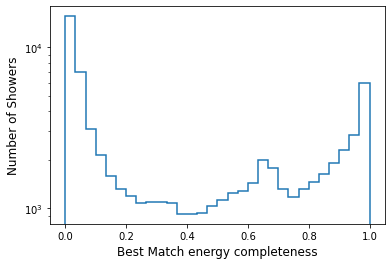

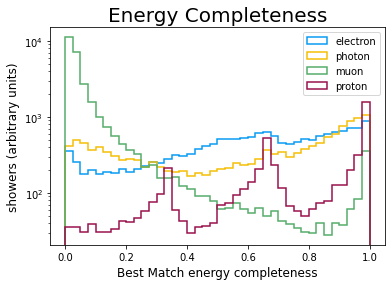

In [8]:
# Energy Completeness (Full sample: No requirement on shower completeness or particle E)

myRange = (0,1)
myBins = 40
myDensity = False
axis_fs = 12
title_fs = 20

mybins = 30
plt.hist(shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
         bins=mybins, histtype = 'step', linewidth = 1.5)
plt.yscale('log')
plt.xlabel('Best Match energy completeness', fontsize = axis_fs)
plt.ylabel('Number of Showers', fontsize = axis_fs)
plt.show()

# Energy Completeness By particle type 

for particle in range(len(particle_labels)):
    plt.hist(particle_shws_no_requirement[particle]['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
             bins=myBins, range=(myRange), 
             color=colors[particle], histtype = 'step', linewidth=1.5, 
             label = particle_labels[particle], density=myDensity)
plt.xlabel("Best Match energy completeness", fontsize = axis_fs)
plt.ylabel('showers (arbitrary units)', fontsize = axis_fs)
plt.yscale("log")
plt.title('Energy Completeness', fontsize = title_fs)
#plt.title('Energy Completeness \n No requirement on \n shower completeness or particle E', fontsize = title_fs)
plt.legend()
plt.show()


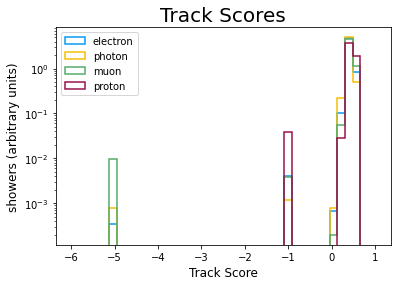

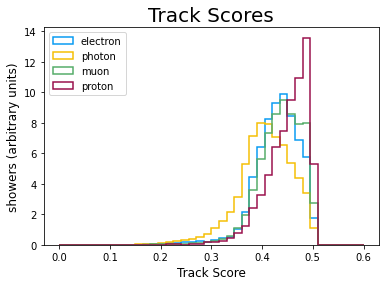

,True Particle,# Shw,# Shw w/ TrackScore = -5,# Shw w/ TrackScore = -1
0,electron,16937,1,12
1,photon,14853,2,3
2,muon,29043,48,20
3,proton,5922,0,41


In [9]:
# TRACK SCORES (Full sample: No requirement on shower completeness or particle E)

myDensity = True

for particle in range(len(particle_labels)):
    plt.hist(particle_shws_no_requirement[particle]['rec.slc.reco.shw.pfp.trackScore'], 
             bins=40, range=(-6,1), 
             color=colors[particle], histtype = 'step', linewidth=1.5, 
             label = particle_labels[particle], density=myDensity)
plt.xlabel("Track Score", fontsize = axis_fs)
plt.ylabel('showers (arbitrary units)', fontsize = axis_fs)
plt.yscale("log")
plt.title('Track Scores', fontsize = title_fs)
plt.legend(loc='upper left')
plt.show()

for particle in range(len(particle_labels)):
    plt.hist(particle_shws_no_requirement[particle]['rec.slc.reco.shw.pfp.trackScore'], 
             bins=40, range=(0,0.6), 
             color=colors[particle], histtype = 'step', linewidth=1.5, 
             label = particle_labels[particle], density=myDensity)
plt.xlabel("Track Score", fontsize = axis_fs)
plt.ylabel('showers (arbitrary units)', fontsize = axis_fs)
#plt.yscale("log")
plt.title('Track Scores', fontsize = title_fs)
plt.legend(loc='upper left')
plt.show()

particle_nshw = []
particle_trkScoreMinus5 = []
particle_trkScoreMinus1 = []
for particle_showers in particle_shws_no_requirement:
    particle_nshw.append(particle_showers.shape[0])
    particle_trkScoreMinus5.append(particle_showers[ particle_showers['rec.slc.reco.shw.pfp.trackScore'] == -5].shape[0] )
    particle_trkScoreMinus1.append(particle_showers[ particle_showers['rec.slc.reco.shw.pfp.trackScore'] == -1].shape[0] )
particle_shws_no_requirement

trackScore_df = pd.DataFrame({'True Particle': particle_labels, 
                     '# Shw': particle_nshw,
                     '# Shw w/ TrackScore = -5': particle_trkScoreMinus5, 
                     '# Shw w/ TrackScore = -1': particle_trkScoreMinus1})
trackScore_df

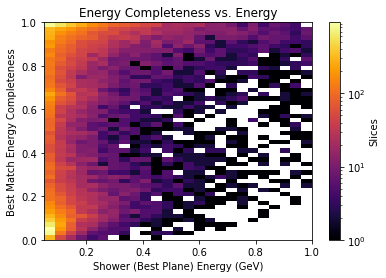

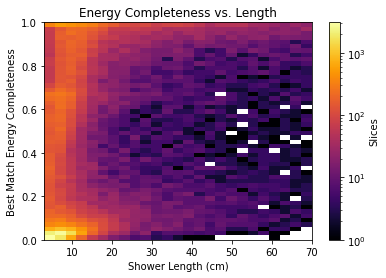

In [11]:
# IMPOSE SOME CUTS TO IGNORE THE REALLY CRUMMY SHOWERS?
# GAUGE SHOWER QUALITY BY ENERGY COMPLETENESS: NIX THE LOW-COMPLETENESS ONES.
# But, I want to be able to cut these showers out using reconstructed info only: can I use energy or shower length?
#      I expect strong correlation between these quantities and the shower completeness.

ybins = 50

# Energy Completeness vs. Energy

fig, ax = plt.subplots(ncols=1)
hb, xedges, yedges, im = ax.hist2d(shw_df['rec.slc.reco.shw.bestplane_energy'], 
                                   shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
                                   bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                   cmin=1, cmap='inferno', range=((0.05,1), (0,1) ))
fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
plt.xlabel('Shower (Best Plane) Energy (GeV)')
plt.ylabel('Best Match Energy Completeness')
plt.title('Energy Completeness vs. Energy')
plt.show()
plt.close()

# Energy Completeness vs. Length

fig, ax = plt.subplots(ncols=1)
hb, xedges, yedges, im = ax.hist2d(shw_df['rec.slc.reco.shw.len'], 
                                   shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
                                   bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                   cmin=1, cmap='inferno', range=((3,70), (0,1) ))
fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
plt.xlabel('Shower Length (cm)')
plt.ylabel('Best Match Energy Completeness')
plt.title('Energy Completeness vs. Length')
plt.show()
plt.close()

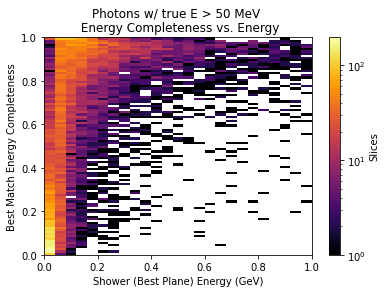

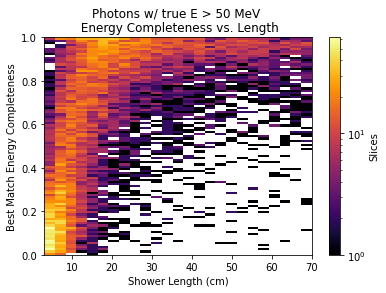

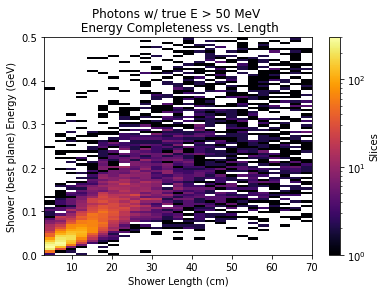

In [12]:
# PHOTONS_SUFF

# Energy Completeness vs. Energy 

fig, ax = plt.subplots(ncols=1)
hb, xedges, yedges, im = ax.hist2d(photons_suff['rec.slc.reco.shw.bestplane_energy'], 
                                   photons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
                                   bins=[25, 100], norm=mpl.colors.LogNorm(),
                                   cmin=1, cmap='inferno', range=((0.0,1.), (0,1) ))
fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
plt.xlabel('Shower (Best Plane) Energy (GeV)')
plt.ylabel('Best Match Energy Completeness')
plt.title('Photons w/ true E > 50 MeV \n Energy Completeness vs. Energy')
plt.show()
plt.close()

# Energy Completeness vs. Length

fig, ax = plt.subplots(ncols=1)
hb, xedges, yedges, im = ax.hist2d(photons_suff['rec.slc.reco.shw.len'], 
                                   photons_suff['rec.slc.reco.shw.truth.bestmatch.energy_completeness'], 
                                   bins=[25, 100], norm=mpl.colors.LogNorm(),
                                   cmin=1, cmap='inferno', range=((3,70), (0,1) ))
fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
plt.xlabel('Shower Length (cm)')
plt.ylabel('Best Match Energy Completeness')
plt.title('Photons w/ true E > 50 MeV \n Energy Completeness vs. Length')
plt.show()
plt.close()

# Energy Completeness vs. Length

fig, ax = plt.subplots(ncols=1)
hb, xedges, yedges, im = ax.hist2d(photons_suff['rec.slc.reco.shw.len'], 
                                   photons_suff['rec.slc.reco.shw.bestplane_energy'], 
                                   bins=[25, 100], norm=mpl.colors.LogNorm(),
                                   cmin=1, cmap='inferno', range=((3,70), (0,0.5) ))
fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
plt.xlabel('Shower Length (cm)')
plt.ylabel('Shower (best plane) Energy (GeV)')
plt.title('Photons w/ true E > 50 MeV \n Energy Completeness vs. Length')
plt.show()
plt.close()

# For now, only consider Complete Showers:
These have a true particle energy > 50 MeV and shower energy completeness > 80%

# Look at shower properties, by true particle type:

In [13]:
print(shw_df.columns)

Index(['rec.slc.reco.shw.bestplane', 'rec.slc.reco.shw.bestplane_energy',
       'rec.slc.reco.shw.plane.0.energy', 'rec.slc.reco.shw.plane.1.energy',
       'rec.slc.reco.shw.plane.2.energy', 'rec.slc.reco.shw.plane.0.nHits',
       'rec.slc.reco.shw.plane.1.nHits', 'rec.slc.reco.shw.plane.2.nHits',
       'rec.slc.reco.shw.plane.0.dEdx', 'rec.slc.reco.shw.plane.0.dEdx',
       'rec.slc.reco.shw.plane.1.dEdx', 'rec.slc.reco.shw.plane.1.dEdx',
       'rec.slc.reco.shw.plane.2.dEdx', 'rec.slc.reco.shw.plane.2.dEdx',
       'rec.slc.reco.shw.open_angle', 'rec.slc.reco.shw.len',
       'rec.slc.reco.shw.dir.x', 'rec.slc.reco.shw.dir.y',
       'rec.slc.reco.shw.dir.z', 'rec.slc.reco.shw.end.x',
       'rec.slc.reco.shw.end.y', 'rec.slc.reco.shw.end.z',
       'rec.slc.reco.shw.start.x', 'rec.slc.reco.shw.start.y',
       'rec.slc.reco.shw.start.z', 'rec.slc.reco.shw.pfp.id',
       'rec.slc.reco.shw.pfp.parent', 'rec.slc.reco.shw.pfp.parent_is_primary',
       'rec.slc.reco.shw.pfp.slcID'

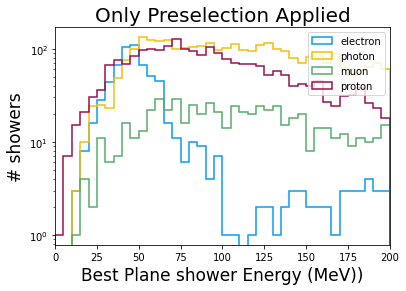

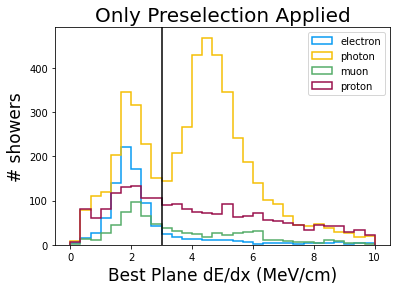

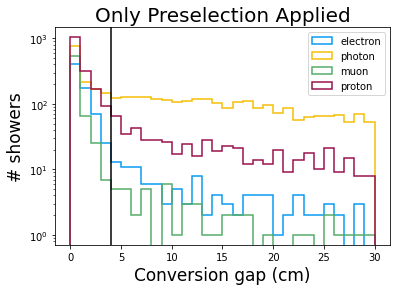

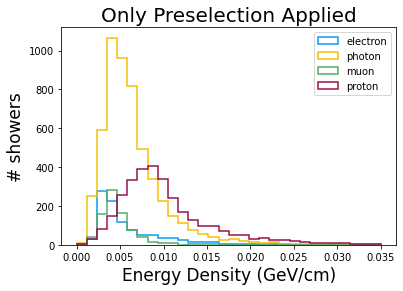

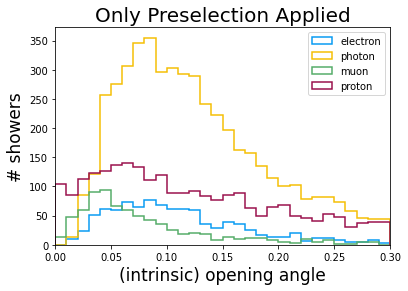

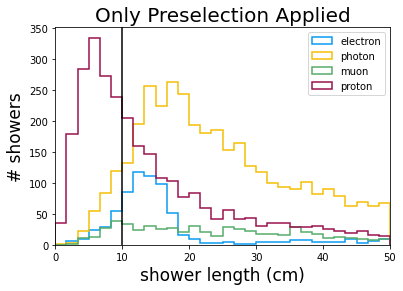

In [11]:
# particle_shws
# particle_labels

def plot_shw_prop_by_particle(list_of_shwdfs, list_of_labels, myDensity=False, plot_title=''):

    axis_fs = 17
    title_fs = 20

    # Energy

    myRange = (0,200.)
    myBins = 40
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.bestplane_energy']*1000., bins=myBins, range=(myRange), 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
    plt.xlabel("Best Plane shower Energy (MeV))", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    plt.yscale("log")
    #plt.xscale("log")
    plt.xlim(myRange)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/energy.pdf")
    plt.show()

    # dE/dx

    dEdxRange = (0,10)
    myBins = 30
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.bestplane_dEdx'], bins=myBins, range=(dEdxRange), 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
        #x = np.percentile(values, 90)
        #print(x)
    plt.axvline(x=dEdx_thresh, color = 'black')
    plt.xlabel("Best Plane dE/dx (MeV/cm)", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    #plt.yscale("log")
    #plt.xscale("log")
    #plt.xlim(xlim)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/dEdx.pdf")
    plt.show()

    # CONVERSION GAP

    congapRange = (0,30)
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.conversion_gap'], bins=myBins, range=(congapRange), 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
    plt.axvline(x=congap_thresh, color = 'black')
    plt.xlabel("Conversion gap (cm)", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    plt.yscale("log")
    #plt.xscale("log")
    #plt.xlim(xlim)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/conv_gap.pdf")
    plt.show()

    # ENERGY DENSITY

    densityRange = (0,0.035)
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.bestplane_energy']/particle_shws[particle]['rec.slc.reco.shw.len'], 
                 bins=myBins, range=(densityRange), 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
    plt.xlabel("Energy Density (GeV/cm)", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    #plt.yscale("log")
    #plt.xscale("log")
    #plt.xlim(xlim)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/Edensity.pdf")
    plt.show()

    # OPENING ANGLE

    shwOpenAngleRange = (0,0.3)#(0,0.8)
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.open_angle'], 
                 bins=myBins, range=(shwOpenAngleRange), 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
    plt.xlabel("(intrinsic) opening angle", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    #plt.yscale("log")
    #plt.xscale("log")
    plt.xlim(shwOpenAngleRange)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/openAngle.pdf")
    plt.show()

    # LENGTH 
    shwLenRange = (0,50)#(0, 175)
    for particle in range(len(list_of_labels)):
        plt.hist(list_of_shwdfs[particle]['rec.slc.reco.shw.len'], 
                 bins=myBins, range=shwLenRange, 
                 color=colors[particle], histtype = 'step', linewidth=1.5, 
                 label = particle_labels[particle], density=myDensity)
    plt.axvline(x=length_thresh, color = 'black') 
    plt.xlabel("shower length (cm)", fontsize = axis_fs)
    if myDensity:
        plt.ylabel('# showers (Area Normalized)', fontsize = axis_fs)
    else:
        plt.ylabel('# showers', fontsize = axis_fs)
    #plt.yscale("log")
    #plt.xscale("log")
    plt.xlim(shwLenRange)
    #plt.ylim(ylim)
    plt.title(plot_title, fontsize = title_fs)
    plt.legend()
    #plt.savefig("/icarus/app/users/jdyer/cm22_pi0/classify_showers/length.pdf")
    plt.show()

plot_shw_prop_by_particle(particle_shws, particle_labels, plot_title='Only Preselection Applied')



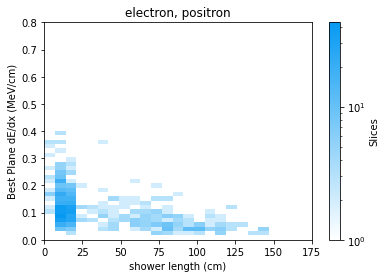

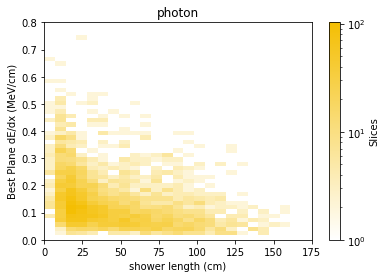

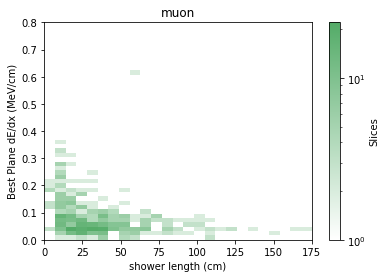

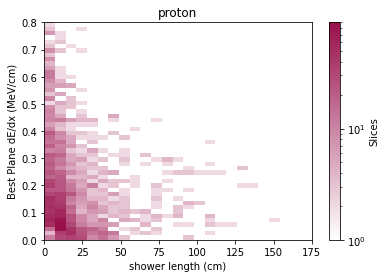

In [12]:
# 2D Plots: (Intrinsic) Opening Angle vs. Length

ybins = 50
for particle in range(len(particle_labels)):
    fig, ax = plt.subplots(ncols=1)
    hb, xedges, yedges, im = ax.hist2d(particle_shws[particle]['rec.slc.reco.shw.len'], 
                                       particle_shws[particle]['rec.slc.reco.shw.open_angle'], 
                                       bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                       cmin=1, cmap=particle_cmaps[particle], 
                                       range=(shwLenRange, shwOpenAngleRange ))
                                        # norm=mpl.colors.LogNorm(), 
    fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
    plt.xlabel('shower length (cm)')
    plt.ylabel('Best Plane dE/dx (MeV/cm)')
    plt.title(particle_labels[particle])
    plt.show()
    plt.close()

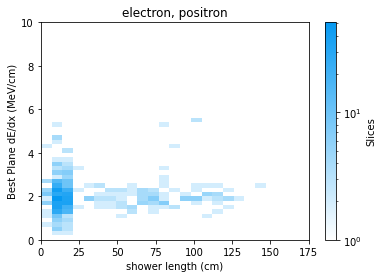

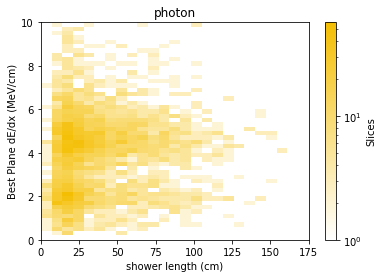

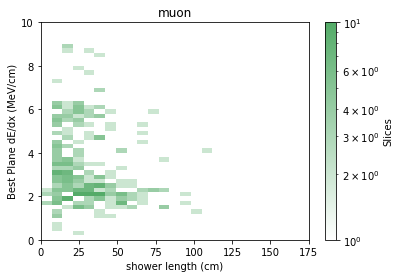

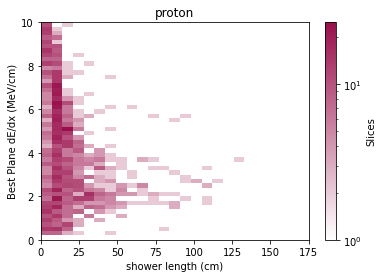

In [14]:
# 2D Plots: dE/dx vs. Length

ybins = 50
for particle in range(len(particle_labels)):
    fig, ax = plt.subplots(ncols=1)
    hb, xedges, yedges, im = ax.hist2d(particle_shws[particle]['rec.slc.reco.shw.len'], 
                                       particle_shws[particle]['rec.slc.reco.shw.bestplane_dEdx'], 
                                       bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                       cmin=1, cmap=particle_cmaps[particle], 
                                       range=(shwLenRange, dEdxRange ))
                                        # norm=mpl.colors.LogNorm(), 
    fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
    plt.xlabel('shower length (cm)')
    plt.ylabel('Best Plane dE/dx (MeV/cm)')
    plt.title(particle_labels[particle])
    plt.show()
    plt.close()

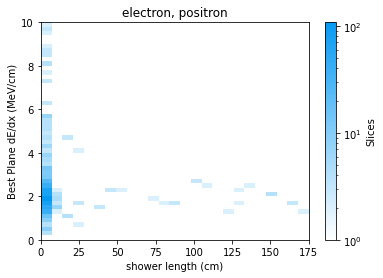

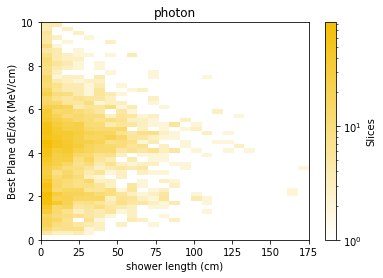

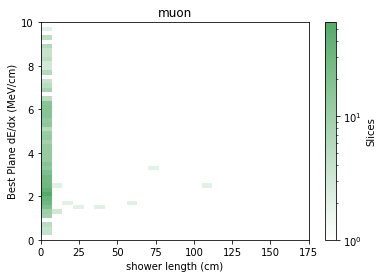

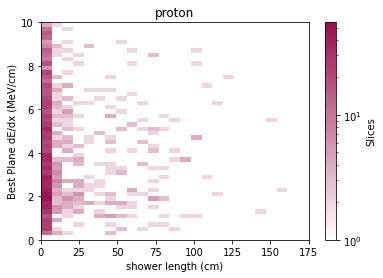

In [15]:
# 2D Plots: dE/dx vs. Conversion Gap

ybins = 50
for particle in range(len(particle_labels)):
    fig, ax = plt.subplots(ncols=1)
    hb, xedges, yedges, im = ax.hist2d(particle_shws[particle]['rec.slc.reco.shw.conversion_gap'], 
                                       particle_shws[particle]['rec.slc.reco.shw.bestplane_dEdx'], 
                                       bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                       cmin=1, cmap=particle_cmaps[particle], 
                                       range=(shwLenRange, dEdxRange ))
                                        # norm=mpl.colors.LogNorm(), 
    fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
    plt.xlabel('shower length (cm)')
    plt.ylabel('Best Plane dE/dx (MeV/cm)')
    plt.title(particle_labels[particle])
    plt.show()
    plt.close()

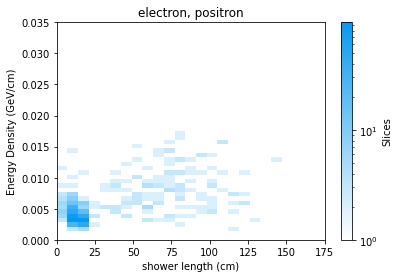

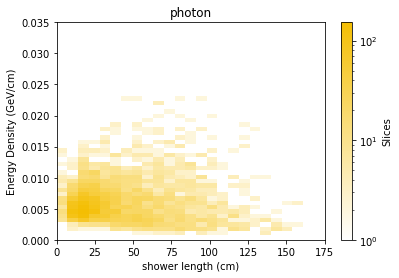

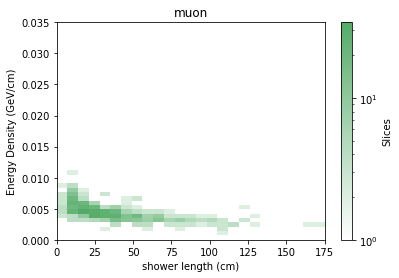

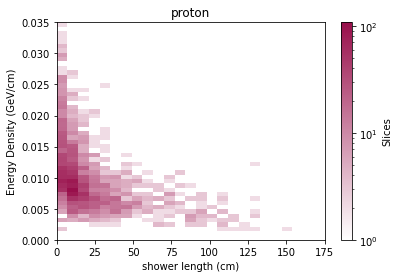

In [16]:
# 2D Plots: Energy Density vs. Length

ybins = 50
for particle in range(len(particle_labels)):
    fig, ax = plt.subplots(ncols=1)
    hb, xedges, yedges, im = ax.hist2d(particle_shws[particle]['rec.slc.reco.shw.len'], 
                                       particle_shws[particle]['rec.slc.reco.shw.bestplane_energy']/particle_shws[particle]['rec.slc.reco.shw.len'], 
                                       bins=[25, ybins], norm=mpl.colors.LogNorm(),
                                       cmin=1, cmap=particle_cmaps[particle], 
                                       range=(shwLenRange, densityRange ))
                                        # norm=mpl.colors.LogNorm(), 
    fig.colorbar(im, ax=ax, label="Slices")#, "log10(Entries)")
    plt.xlabel('shower length (cm)')
    plt.ylabel('Energy Density (GeV/cm)')
    plt.title(particle_labels[particle])
    plt.show()
    plt.close()

# Select Photons

- Start with sample of all showers that survive preselection.
- Apply cuts to select photons.
- See 


In [12]:
all_preselected = [electrons, photons, muons, protons]
for i in all_preselected:
    print(i.shape)
print('')
preselected_survive_reco_cuts = []
denom_survive_reco_cuts = 0
for particle in range(len(particle_labels)):
    preselected_survive_reco_cuts.append(all_preselected[particle].query(
        '`rec.slc.reco.shw.bestplane_dEdx` >= @dEdx_thresh & \
        `rec.slc.reco.shw.conversion_gap` >= @congap_thresh'))
    #print(all_preselected[particle].query(
    #    '`rec.slc.reco.shw.bestplane_dEdx` >= @dEdx_cut & \
    #    `rec.slc.reco.shw.conversion_gap` >= @congap_cut').shape)
    #denom_survive_reco_cuts = denom_survive_reco_cuts +
eff = preselected_survive_reco_cuts[1].shape[0]/all_preselected[1].shape[0]
pur = preselected_survive_reco_cuts[1].shape[0]/sum([i.shape[0] for i in preselected_survive_reco_cuts])
print('The efficieny, purity for all photons are:', eff, pur, '\n', sep='\n')

well_reco = [complete_electrons, complete_photons, complete_muons, complete_protons]
well_reco_survive_reco_cuts = []
for particle in range(len(particle_labels)):
    well_reco_survive_reco_cuts.append(well_reco[particle].query(
        '`rec.slc.reco.shw.bestplane_dEdx` >= @dEdx_thresh & \
        `rec.slc.reco.shw.conversion_gap` >= @congap_thresh'))
well_reco_eff = well_reco_survive_reco_cuts[1].shape[0]/well_reco[1].shape[0]
well_reco_pur = well_reco_survive_reco_cuts[1].shape[0]/sum([i.shape[0] for i in well_reco_survive_reco_cuts])
print('The efficieny, purity for just the well reconstructed photons (true particle energy > 50 MeV and energy completeness > 80%) are:', 
      well_reco_eff, well_reco_pur, sep='\n')

(16937, 85)
(14853, 85)
(29043, 85)
(5922, 85)

The efficieny, purity for all photons are:
0.35716690230929776
0.4408709382531372


The efficieny, purity for just the well reconstructed photons (true particle energy > 50 MeV and energy completeness > 80%) are:
0.5313025602691086
0.7118177265898848


In [13]:
# DEFINE THE CUTS

def no_cut(df, placeholder=0, label='No cut'):
    return df, label 

#def preselection(df):
#    return 

def dEdx_cut(df, min_accept=dEdx_thresh):
    new_df = df.query('`rec.slc.reco.shw.bestplane_dEdx` >= @min_accept')
    return new_df, 'dE/dx >= %d MeV/cm' % min_accept

def convgap_cut(df, min_accept=congap_thresh):
    new_df = df.query('`rec.slc.reco.shw.conversion_gap` >= @min_accept')
    return new_df, 'Conversion gap >= %d cm' % min_accept

def length_cut(df, min_accept=length_thresh):
    new_df = df.query('`rec.slc.reco.shw.len` >= @min_accept')
    return new_df, 'Length >= %d cm' % min_accept



In [111]:
# INITIALIZE THE DATAFRAME

# particle_labels = ['electron', 'photon', 'muon', 'proton']

# List by particle type of ENITRE SAMPLE (before preselection):

# List of shower dataframes that passed preselection, by particle type:
#        particle_shws_no_requirement 
#....Not sorted by particle type:
#        shw_df
#....Just the photons:
#        photons (photons = shw_df[(shw_df['rec.slc.reco.shw.truth.p.pdg'] == 22)])

##sample_names = ['50MeV', '100MeV', '150MeV', '200MeV', 'all_bg', 'cosmics', 'NC', 'CC']


## THIS MAKES A VERY NICE DATA FRAME, BUT IS NOT WHAT I WANT HERE. 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names
'''
particle_col_labels = []
row = []
for p in range(len(particle_labels)):
    for i in range(3):
        particle_col_labels.append(particle_labels[p])
    row.append(particle_shws_no_requirement[p].shape[0]) # n showers in sample
    row.append(1.) # efficiency 
    row.append(particle_shws_no_requirement[1].shape[0]/sum([i.shape[0] for i in particle_shws_no_requirement])) #purity
cut_results_df = pd.DataFrame({'particle': particle_col_labels,'quantity':['counts','eff','pur']*len(particle_labels)})
cut_results_df = cut_results_df.set_index(['particle','quantity']).transpose()
cut_results_df.loc['full sample (after preselection)'] = row
cut_results_df
'''

# WANT: purity to go up; efficiency to stay high.



,#_e_shw,#_γ_shw,#_μ_shw,#_p_shw,γ_eff,γ_pur


In [23]:
# DEFINE FUNCTION TO APPLY CUTS

def apply_cuts(starting_sample, no_cut_label='No cut'): #starting sample should be a list of dataframes by particle type.

    col_names = ['#_e_shw', '#_\u03B3_shw', '#_\u03BC_shw', '#_p_shw', '\u03B3_eff', '\u03B3_pur']

    cut_results_df = pd.DataFrame(
        np.zeros((0,len(col_names)), dtype=int), # start w/ zero rows (cuts), fill later
        columns = col_names
    )

    cuts = [
        no_cut,
        dEdx_cut,
        convgap_cut,
        length_cut
    ]
    
    thresholds = [
        0,
        dEdx_thresh,
        congap_thresh, 
        length_thresh
    ]
    
    new_samples = starting_sample[:] # see explanation here: https://stackoverflow.com/questions/4588100/python-objects-confusion-a-b-modify-b-and-a-changes
    for cut_ind in range(len(cuts)):
        row = []
        eff = -1.
        pur = -1.
        for p in range(len(new_samples)):
            if cut_ind == 0:
                func_output = cuts[cut_ind](new_samples[p], thresholds[cut_ind], label=no_cut_label)
            else:
                func_output = cuts[cut_ind](new_samples[p], thresholds[cut_ind])
            row.append(func_output[0].shape[0])
            if p == 1:
                n_photons = func_output[0].shape[0]
            new_samples[p] = func_output[0]
        eff = n_photons/starting_sample[1].shape[0]
        pur = n_photons/sum(row[:4])
        row.append(eff)
        row.append(pur)
        cut_results_df.loc[func_output[1]] = row 
    return cut_results_df, new_samples
    #all_that_pass_cuts = pd.concat((i for i in new_samples))

In [21]:
# RESULTS FOR ALL SHOWERS THAT PASS THE PRESELECTION

#del full_sample_results
full_sample_results = apply_cuts(all_preselected, no_cut_label='Full sample (after preselection)')    
full_sample_results[0]

,#_e_shw,#_γ_shw,#_μ_shw,#_p_shw,γ_eff,γ_pur
Full sample (after preselection),16937.0,14853.0,29043.0,5922.0,1.000000,0.222500
dE/dx >= 3 MeV/cm,2636.0,7371.0,8234.0,4079.0,0.496263,0.330242
Conversion gap >= 4 cm,1333.0,5305.0,3691.0,1704.0,0.357167,0.440871
Length >= 10 cm,425.0,4180.0,1422.0,670.0,0.281425,0.624160


In [22]:
# REPEAT FOR JUST THE WELL RECONSTRUCTED SHOWERS 
# true part. E > 50 MeV & E completeness > 80%, 

#del wellRecod_results
wellRecod_results = apply_cuts(well_reco, no_cut_label='Well Recod Shw (after preselection)')    
wellRecod_results[0]

,#_e_shw,#_γ_shw,#_μ_shw,#_p_shw,γ_eff,γ_pur
Well Recod Shw (after preselection),1006.0,5351.0,811.0,3115.0,1.000000,0.520373
dE/dx >= 3 MeV/cm,209.0,3665.0,405.0,2173.0,0.684919,0.568041
Conversion gap >= 4 cm,71.0,2843.0,70.0,1010.0,0.531303,0.711818
Length >= 10 cm,62.0,2747.0,50.0,502.0,0.513362,0.817316


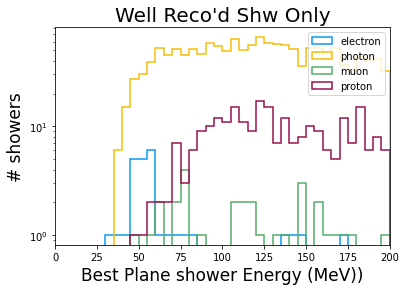

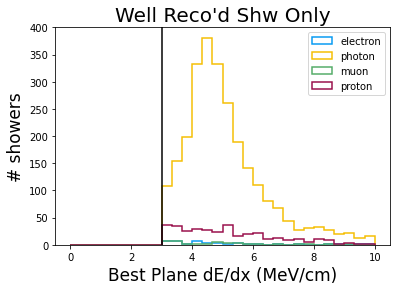

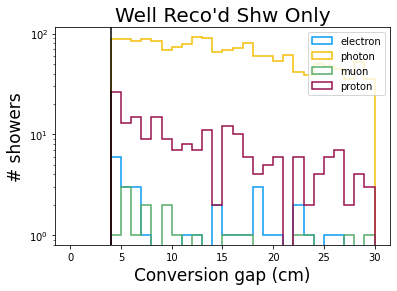

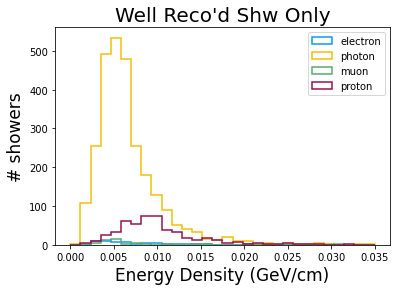

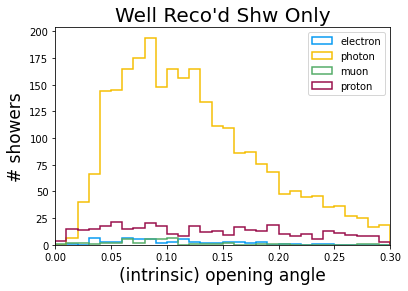

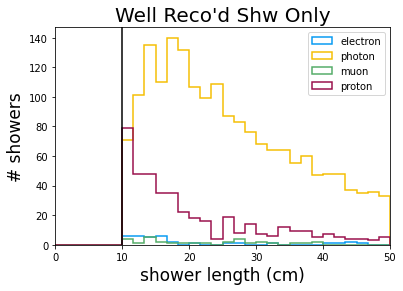

In [25]:
plot_shw_prop_by_particle(wellRecod_results[1], particle_labels, myDensity=False, plot_title="Well Reco'd Shw Only")

4
(1704, 85)
(5305, 85)
(3691, 85)
(1704, 85)


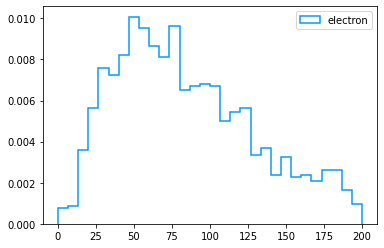

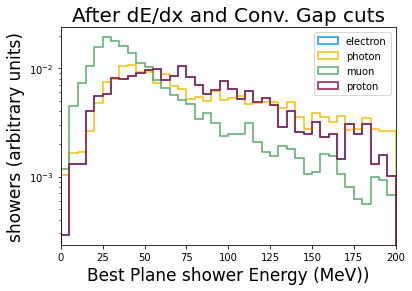

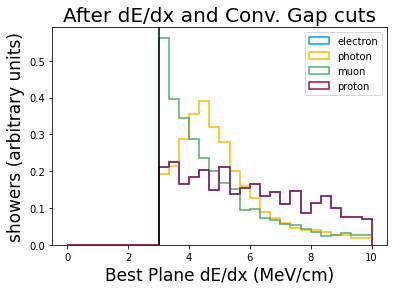

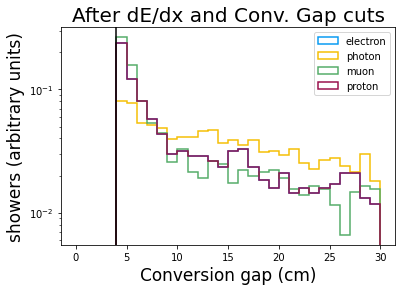

/cvmfs/larsoft.opensciencegrid.org/products/numpy/v1_20_1/Linux64bit+3.10-2.17-e20-p392/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


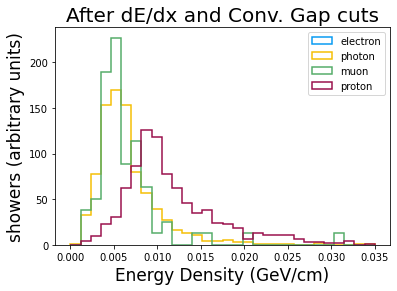

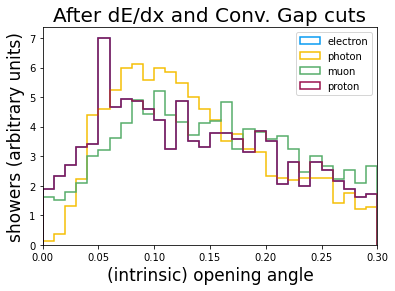

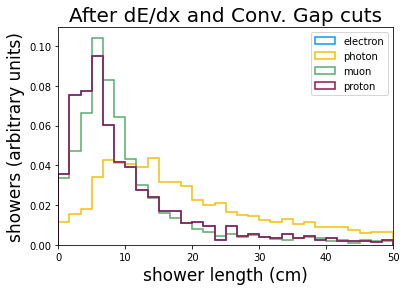

In [121]:
print(len(new_samples))
for i in new_samples:
    print(i.shape)


plt.hist(new_samples[0]['rec.slc.reco.shw.bestplane_energy']*1000., bins=myBins, range=(myRange), 
         color=colors[0], histtype = 'step', linewidth=1.5, 
         label = particle_labels[0], density=True)
plt.legend()
plt.show()

plot_shw_prop_by_particle(new_samples, particle_labels, plot_title='After dE/dx and Conv. Gap cuts', myDensity=True)



# Scratch

In [ ]:
# SKIP CELL

print('all showers: ', shw_df.shape)

true_photon_shws = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == 22]
print('photons: ', true_photon_shws.shape)

true_e_shws = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == 11]
print('electrons: ', true_e_shws.shape)

true_eplus_shws = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == -11]
print('positrons: ', true_eplus_shws.shape)

true_mu_shws = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == 13]
print('muons: ', true_mu_shws.shape)

true_p_shws = shw_df[shw_df['rec.slc.reco.shw.truth.p.pdg'] == 2212]
print('protons: ', true_p_shws.shape)

In [ ]:
# SKIP CELL

shw_true_pdg = shw_df['truth.p.pdg']
shw_best_match_pdg = shw_df['bestmatch.pdg']

unique_list = []
for x in shw_true_pdg:# + shw_best_match_pdg:
    if x not in unique_list:
        #print(x)
        unique_list.append(x)
print(len(unique_list))

pdg_dict = {
    13: '\u03BC-', #'muon',
    -13: '\u03BC+', 
    11: 'e-',
    -11: 'e+',
    22: '\u03B3', #'photon',
    2212: 'proton',
    211: '\u03C0+',
    -211: '\u03C0-',
    1000010020: 'deuteron',
    -5: 'bad news bears'
}

print(pdg_dict[13])


In [12]:
from mpl_toolkits import mplot3d

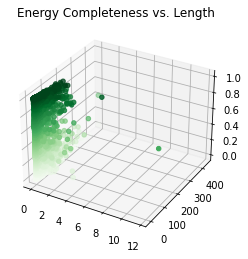

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(shw_df['rec.slc.reco.shw.bestplane_energy'],
             shw_df['rec.slc.reco.shw.len'],
             shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'],
             c=shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'],
             cmap='Greens')
#plt.xlabel('Shower (Best Plane) Energy (GeV)')
#plt.ylabel('Shower Length ()')
#plt.zlabel('Best Match Energy Completeness')
plt.title('Energy Completeness vs. Length')
plt.show()

In [69]:
# Create DataFrame

mydf = pd.DataFrame({'energy': np.array(shw_df['rec.slc.reco.shw.bestplane_energy']), 
                     'length': np.array(shw_df['rec.slc.reco.shw.len']),
                     'completeness': np.array(shw_df['rec.slc.reco.shw.truth.bestmatch.energy_completeness'])})

fig = px.scatter_3d(mydf, x='energy', y='length', z='completeness',color='completeness',
                   range_x=(0,0.5), range_y=(0,100), range_z=(0,1) )


In [70]:
mydf

,energy,length,completeness
0,0.202860,15.871977,1.000000
1,0.036665,6.162296,0.031005
2,0.014311,1.109661,0.010013
3,0.177253,3.840431,0.089654
4,0.641089,70.905121,0.823335
...,...,...,...
69001,0.051318,6.173324,0.801040
69002,0.023488,3.497322,0.016507
69003,0.125705,23.942860,0.131604
69004,0.055680,13.035578,0.089941


In [20]:
df = px.data.iris()
df

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,3
146,6.3,2.5,5.0,1.9,virginica,3
147,6.5,3.0,5.2,2.0,virginica,3
148,6.2,3.4,5.4,2.3,virginica,3
